In [1]:
!pip install neurokit2


import pandas as pd
import numpy as np
import scipy
import neurokit2 as nk
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
from time import time
from sys import getsizeof

start = time()
eda_data: pd.DataFrame = pd.read_csv(
    "./example_data_w_engagement.csv", index_col=0
)
print("Loading time %.2fs" % (time() - start))
print(f"EDA data size: %.2fMB" % (getsizeof(eda_data) / 1e6))
# convert the timestamp column to the correct class
eda_data["timestamp"] = pd.to_datetime(
    eda_data["timestamp"], format="mixed"
)

Loading time 0.15s
EDA data size: 62.78MB


In [2]:
!pip install neurokit2


import pandas as pd
import numpy as np
import scipy
import neurokit2 as nk
import seaborn as sns
import plotly
import matplotlib.pyplot as plt
from time import time
from sys import getsizeof

start = time()
eda_data: pd.DataFrame = pd.read_csv(
    "./example_data_w_engagement.csv", index_col=0
)
print("Loading time %.2fs" % (time() - start))
print(f"EDA data size: %.2fMB" % (getsizeof(eda_data) / 1e6))
# convert the timestamp column to the correct class
eda_data["timestamp"] = pd.to_datetime(
    eda_data["timestamp"], format="mixed"
)

Loading time 0.13s
EDA data size: 62.78MB


In [3]:
display(eda_data.head())

,username,session,timestamp,EDA,engagement
61039,S003,27Feb,2017-02-27 08:32:00.250000+01:00,2.869309,0.0
61040,S003,27Feb,2017-02-27 08:32:00.500000+01:00,2.866625,0.0
61041,S003,27Feb,2017-02-27 08:32:00.750000+01:00,2.862869,0.0
61042,S003,27Feb,2017-02-27 08:32:01+01:00,2.859894,0.0
61043,S003,27Feb,2017-02-27 08:32:01.250000+01:00,2.859772,0.0


In [4]:
import numpy as np
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
def butter_lowpass_filter_filtfilt(data, fs, cutoff, order=1):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist

    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

In [5]:

eda_data["filt-EDA"] = (
    eda_data.groupby(["username", "session"], group_keys=False)
    .apply(
        lambda x: butter_lowpass_filter_filtfilt(
            data=x["EDA"], fs=4, cutoff=0.4, order=1
        )
    )
    .explode()
    .values
)

/var/folders/zk/v9jj5r812vq0zxdfwnwy_dgw0000gn/T/ipykernel_42611/1279652115.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [6]:
display(eda_data.head())

,username,session,timestamp,EDA,engagement,filt-EDA
61039,S003,27Feb,2017-02-27 08:32:00.250000+01:00,2.869309,0.0,2.86933
61040,S003,27Feb,2017-02-27 08:32:00.500000+01:00,2.866625,0.0,2.866828
61041,S003,27Feb,2017-02-27 08:32:00.750000+01:00,2.862869,0.0,2.864549
61042,S003,27Feb,2017-02-27 08:32:01+01:00,2.859894,0.0,2.86297
61043,S003,27Feb,2017-02-27 08:32:01.250000+01:00,2.859772,0.0,2.862508


In [7]:
def normalize_signals(signal):
    return (signal - signal.min()) / (signal.max() - signal.min())
    
eda_data["norm-EDA"] = (
    eda_data.groupby(["username", "session"])
    .apply(lambda x: normalize_signals(x["filt-EDA"]))
    .explode()
    .values
)

/var/folders/zk/v9jj5r812vq0zxdfwnwy_dgw0000gn/T/ipykernel_42611/1282344227.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: normalize_signals(x["filt-EDA"]))


In [8]:
display(eda_data.head())

,username,session,timestamp,EDA,engagement,filt-EDA,norm-EDA
61039,S003,27Feb,2017-02-27 08:32:00.250000+01:00,2.869309,0.0,2.86933,0.989116
61040,S003,27Feb,2017-02-27 08:32:00.500000+01:00,2.866625,0.0,2.866828,0.988253
61041,S003,27Feb,2017-02-27 08:32:00.750000+01:00,2.862869,0.0,2.864549,0.987467
61042,S003,27Feb,2017-02-27 08:32:01+01:00,2.859894,0.0,2.86297,0.986923
61043,S003,27Feb,2017-02-27 08:32:01.250000+01:00,2.859772,0.0,2.862508,0.986763


In [9]:
window_size_in_sec: int = 10
spl_rate: int = 4
window_size_in_sampling_rate: int = window_size_in_sec * spl_rate

In [10]:
def create_segments(
    x: pd.DataFrame, window_size_in_sampling_rate: int
) -> list[pd.DataFrame]:
    starts: pd.Series = x[::window_size_in_sampling_rate]["timestamp"]
    ends: pd.Series = (
        starts
        + pd.Timedelta(f"{window_size_in_sec}s")
        - pd.Timedelta(f"{1/spl_rate}s")
    )

    x = x.set_index("timestamp")
    segments: list[pd.DataFrame] = [
        x.loc[start:end] for start, end in zip(starts, ends)
    ]
    return segments

In [11]:
import warnings

def segment_and_extract(x: pd.DataFrame, window_size_in_sampling_rate: int) -> pd.DataFrame:
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", RuntimeWarning)

    segments = create_segments(x, window_size_in_sampling_rate)

    extracted_features: list[tuple[pd.Series, int]] = [
        (
            extract_features(
                data=segment["norm-EDA"].values.astype(float),
                sampling_rate=spl_rate,
            ),
            segment["engagement"].mean(),
        )
        for segment in segments
        if segment["engagement"].mean() == 0
        or segment["engagement"].mean() == 1
    ]

    engagement_values = [eng for _, eng in extracted_features]
    extracted_features = [feat for feat, _ in extracted_features]
    extracted_features = pd.concat(extracted_features, axis=1).T
    extracted_features["engagement"] = engagement_values
    return extracted_features


In [12]:
from tqdm.auto import tqdm
tqdm.pandas()

In [13]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

def extract_features(data: np.ndarray, sampling_rate: int) -> pd.Series:

    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    std_val = np.std(data)

    peaks, _ = find_peaks(data)
    num_peaks = len(peaks)

    rise_time = np.percentile(data, 90) - np.percentile(data, 10)

    decay_time = np.percentile(data, 90) - np.percentile(data, 10)

    dynamic_range = max_val - min_val

    slope = (data[-1] - data[0]) / len(data)

    abs_slope = abs(slope)


    first_derivative = np.diff(data)
    first_derivative_mean = np.mean(first_derivative)
    first_derivative_std = np.std(first_derivative)
    features = pd.Series({
        "Min": min_val,
        "Max": max_val,
        "Mean": mean_val,
        "Std": std_val,
        "Num Peaks": num_peaks,
        "Rise Time": rise_time,
        "Decay Time": decay_time,
        "Dynamic Range": dynamic_range,
        "Slope": slope,
        "Absolute Slope": abs_slope,
        "First Derivative Mean": first_derivative_mean,
        "First Derivative Std": first_derivative_std
    })

    return features


In [14]:
# NOTE: this can take around 10/20 seconds to run
# NOTE: .progress_apply() works only because we run tqdm.pandas(). Otherwise, you need to use
# the traditional .apply() method
eda_features = eda_data.groupby(["username", "session"]).progress_apply(
    lambda x: segment_and_extract(x, window_size_in_sampling_rate)
)

  0%|          | 0/13 [00:00<?, ?it/s]

In [15]:
eda_features.head() 

Min       Max      Mean       Std  Num Peaks  \
username session                                                        
S003     27Feb   0  0.984190  1.000000  0.991249  0.004542        1.0   
                 1  0.941819  0.985279  0.962516  0.018179        2.0   
                 2  0.949165  0.973538  0.959929  0.007300        2.0   
                 3  0.896443  0.956325  0.926374  0.021163        1.0   
                 4  0.882804  0.898810  0.891899  0.005909        2.0   

                    Rise Time  Decay Time  Dynamic Range     Slope  \
username session                                                     
S003     27Feb   0   0.011827    0.011827       0.015810 -0.000123   
                 1   0.042358    0.042358       0.043459 -0.000790   
                 2   0.020391    0.020391       0.024372  0.000035   
                 3   0.054662    0.054662       0.059882 -0.001497   
                 4   0.014594    0.014594       0.016005 -0.000218   

                    Absolute Slope  First Derivative Mean  \
username session                                            
S003     27Feb   0        0.000123              -0.000126   
                 1        0.000790              -0.000810   
                 2        0.000035               0.000036   
                 3        0.001497              -0.001535   
                 4        0.000218              -0.000224   

                    First Derivative Std  engagement  
username session                                      
S003     27Feb   0              0.000886         0.0  
                 1              0.001927         0.0  
                 2              0.001581         0.0  
                 3              0.001105         0.0  
                 4              0.000919         0.0

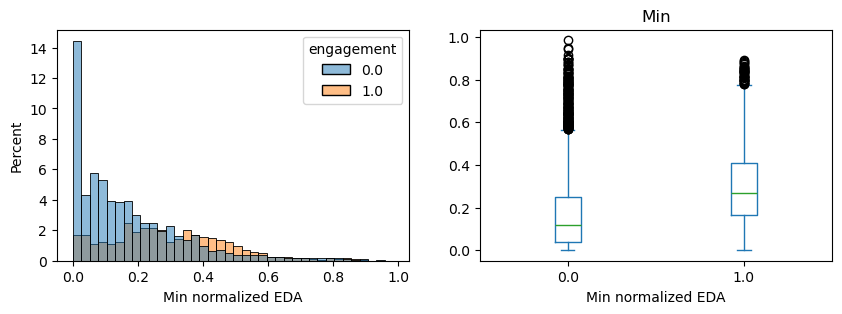

In [16]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="Min",
    hue="engagement",
    stat="percent",
)
eda_features.plot.box(ax=axs[1], column="Min", by="engagement")
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

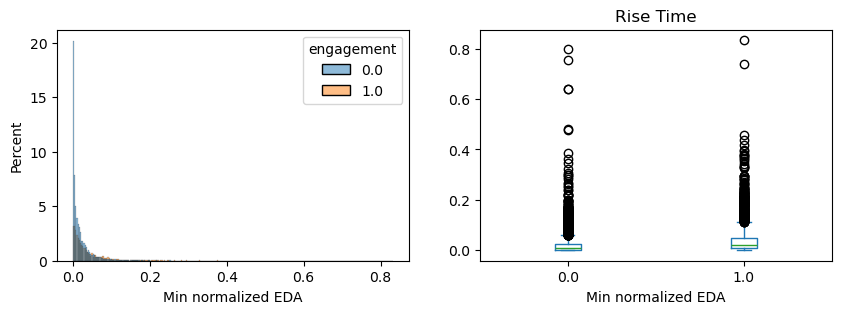

In [17]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="Rise Time",
    hue="engagement",
    stat="percent",
)
eda_features.plot.box(ax=axs[1], column="Rise Time", by="engagement")
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

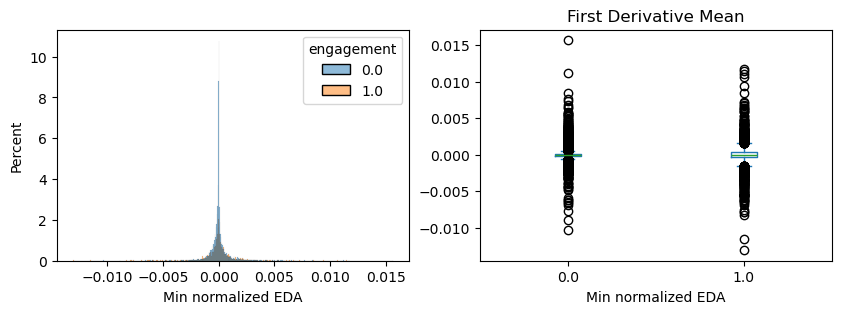

In [18]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="First Derivative Mean",
    hue="engagement",
    stat="percent",
)
eda_features.plot.box(
    ax=axs[1], column="First Derivative Mean", by="engagement"
)
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

In [19]:
# perform correlation
pearson_cor = eda_features.corr(method="pearson")["engagement"]
display(pearson_cor)

Min                      0.325177
Max                      0.351228
Mean                     0.345755
Std                      0.201542
Num Peaks               -0.053341
Rise Time                0.203704
Decay Time               0.203704
Dynamic Range            0.210097
Slope                    0.005641
Absolute Slope           0.181436
First Derivative Mean    0.005642
First Derivative Std     0.205880
engagement               1.000000
Name: engagement, dtype: float64

In [20]:
# perform correlation
kendall_cor = eda_features.corr(method="kendall")["engagement"]
display(kendall_cor)

Min                      0.294412
Max                      0.330711
Mean                     0.319585
Std                      0.248285
Num Peaks               -0.040420
Rise Time                0.247658
Decay Time               0.247658
Dynamic Range            0.252312
Slope                    0.008268
Absolute Slope           0.213658
First Derivative Mean    0.008267
First Derivative Std     0.262522
engagement               1.000000
Name: engagement, dtype: float64

In [21]:
# perform t-test between features based on the engagement level
from scipy.stats import ttest_ind


def ttest_features(x: pd.DataFrame, feature: str) -> float:
    return ttest_ind(
        x[x["engagement"] == 0][feature].values,
        x[x["engagement"] == 1][feature].values,
    )[1]


t_test_results = eda_features.apply(
    lambda x: ttest_features(eda_features, x.name), axis=0
)
t_test_results = pd.DataFrame(t_test_results, columns=["p-value"])
t_test_results["above_threshold"] = t_test_results["p-value"] < 0.05

In [22]:
display(t_test_results)

,p-value,above_threshold
Min,8.853300e-183,True
Max,5.893640e-215,True
Mean,6.173578e-208,True
Std,4.845206e-69,True
Num Peaks,4.155772e-06,True
Rise Time,1.602662e-70,True
Decay Time,1.602662e-70,True
Dynamic Range,5.341873e-75,True
Slope,6.266458e-01,False
Absolute Slope,4.384682e-56,True


In [23]:
# perform cliff's delta effect size between features
!pip install effect_size_analysis

import pandas as pd
from effect_size_analysis.cliff_delta import cliff_delta


def calculate_cliff_delta(
    x: pd.DataFrame, feature: str, alpha: float = 0.05
) -> pd.Series:
    return cliff_delta(
        s1=x[x["engagement"] == 0][feature].values,
        s2=x[x["engagement"] == 1][feature].values,
        alpha=alpha,
        accurate_ci=False,
        raise_nan=False,
    )


# NOTE: this can take a while to run (around 1/2 minutes)
effect_size_results = eda_features.progress_apply(
    lambda x: calculate_cliff_delta(eda_features, x.name), axis=0
)
effect_size_results = effect_size_results.T
effect_size_results.columns = ['mean_delta', 'confidence_interval_delta']

  0%|          | 0/13 [00:00<?, ?it/s]

In [24]:
display(effect_size_results)

,mean_delta,confidence_interval_delta
Min,-0.435521,"(-0.46524269299882975, -0.40579888114799495)"
Max,-0.489217,"(-0.5199532756734679, -0.4584812190132045)"
Mean,-0.472759,"(-0.5030548851099411, -0.4424640547297038)"
Std,-0.367285,"(-0.3986091912108051, -0.3359607133023918)"
Num Peaks,0.050602,"(0.01800934396861445, 0.08319376191457205)"
Rise Time,-0.366357,"(-0.3976966993442678, -0.3350180637226969)"
Decay Time,-0.366357,"(-0.3976966993442678, -0.3350180637226969)"
Dynamic Range,-0.373242,"(-0.40430228532043394, -0.3421819606855557)"
Slope,-0.01223,"(-0.039708955942432865, 0.015248291267236027)"
Absolute Slope,-0.316062,"(-0.34778035717354355, -0.28434272173496905)"


In [25]:
display(effect_size_results.iloc[:,0])

Min                     -0.435521
Max                     -0.489217
Mean                    -0.472759
Std                     -0.367285
Num Peaks                0.050602
Rise Time               -0.366357
Decay Time              -0.366357
Dynamic Range           -0.373242
Slope                    -0.01223
Absolute Slope          -0.316062
First Derivative Mean    -0.01223
First Derivative Std    -0.388345
engagement                   -1.0
Name: mean_delta, dtype: object

In [26]:
X = eda_features.drop("engagement", axis=1).values
y = eda_features["engagement"].values

<Axes: >

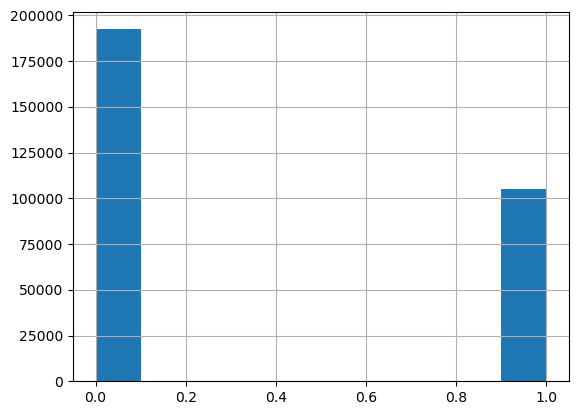

In [27]:
eda_data["engagement"].hist()

In [28]:
groups: np.ndarray = eda_features.index.get_level_values(0).values

In [29]:
# load xgboost and cross validation
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score

# perform cross validation with xgboost and balanced accuracy
xgb = XGBClassifier(random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_xgboost = cross_validate(
    xgb,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)

In [30]:
# load random classifier and cross validation
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

# perform cross validation with xgboost and balanced accuracy
model = DummyClassifier(strategy="uniform", random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_dummy = cross_validate(
    model,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)

In [31]:
print(
    f"Average validation score of XGBoost: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_xgboost["test_score"]),
        100 * np.std(cv_results_xgboost["test_score"]),
    )
)
print(
    f"Average validation score of DummyClassifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_dummy["test_score"]),
        100 * np.std(cv_results_dummy["test_score"]),
    )
)

Average validation score of XGBoost: 69.19 ± 0.96 %
Average validation score of DummyClassifier: 47.58 ± 0.31 %


In [32]:
from sklearn.utils import shuffle

X, y, groups = shuffle(X, y, groups, random_state=42)

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.dummy import DummyClassifier

# perform cross validation with xgboost and balanced accuracy
xgb = XGBClassifier(random_state=42)
baseline = DummyClassifier(strategy="uniform", random_state=42)
groups_instance = LeaveOneGroupOut()
cv_results_xgboost = cross_validate(
    xgb,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_results_dummy = cross_validate(
    baseline,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)

In [34]:
print(
    f"Average validation score of XGBoost: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_xgboost["test_score"]),
        100 * np.std(cv_results_xgboost["test_score"]),
    )
)
print(
    f"Average validation score of DummyClassifier: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_dummy["test_score"]),
        100 * np.std(cv_results_dummy["test_score"]),
    )
)

Average validation score of XGBoost: 45.87 ± 23.35 %
Average validation score of DummyClassifier: 49.47 ± 1.02 %


In [35]:
#Question2:

In [36]:
print(eda_features.columns)


Index(['Min', 'Max', 'Mean', 'Std', 'Num Peaks', 'Rise Time', 'Decay Time',
       'Dynamic Range', 'Slope', 'Absolute Slope', 'First Derivative Mean',
       'First Derivative Std', 'engagement'],
      dtype='object')


In [37]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

# Load data
eda_data = pd.read_csv("./example_data_w_engagement.csv", index_col=0)
eda_data["timestamp"] = pd.to_datetime(eda_data["timestamp"], format="mixed")

# Preprocess: Group by day, treat each user's different date as a "group"
eda_data['date'] = eda_data['timestamp'].dt.date
eda_data['user_date'] = eda_data['username'].astype(str) + "_" + eda_data['date'].astype(str)

# Feature extraction (assuming features are extracted and stored in 'eda_features')
X = eda_data.drop(columns=['engagement', 'timestamp', 'date', 'user_date', 'username', 'session'])  # Remove 'username' and 'session'
y = eda_data['engagement']  # Target variable

# Shuffle data for randomization in cross-validation
X, y = shuffle(X, y, random_state=42)

# Use LeaveOneGroupOut for cross-validation, grouping by each user's different date
groups = eda_data['user_date']  # Each user's date is treated as a group

# XGBoost model
xgb = XGBClassifier(random_state=42)

# DummyClassifier model (random classifier)
dummy_model = DummyClassifier(strategy="uniform", random_state=42)

# Initialize LeaveOneGroupOut cross-validation
logo = LeaveOneGroupOut()

# Cross-validation with XGBoost
cv_results_xgboost = cross_validate(
    xgb,
    X,
    y,
    cv=logo.split(X, y, groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)

# Cross-validation with DummyClassifier
cv_results_dummy = cross_validate(
    dummy_model,
    X,
    y,
    cv=logo.split(X, y, groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)

# Output results for XGBoost model
print(f"Average validation score of XGBoost: %.2f ± %.2f %%"
      % (
          100 * np.mean(cv_results_xgboost["test_score"]),
          100 * np.std(cv_results_xgboost["test_score"]),
      ))

# Output results for DummyClassifier model
print(f"Average validation score of DummyClassifier: %.2f ± %.2f %%"
      % (
          100 * np.mean(cv_results_dummy["test_score"]),
          100 * np.std(cv_results_dummy["test_score"]),
      ))


Average validation score of XGBoost: 68.51 ± 0.18 %
Average validation score of DummyClassifier: 50.05 ± 0.21 %


In [1]:
#Question3
#import 4 different models to validate

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_validate, KFold
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from tqdm import tqdm

# Load data
eda_data = pd.read_csv("./example_data_w_engagement.csv", index_col=0)
eda_data["timestamp"] = pd.to_datetime(eda_data["timestamp"], format="mixed")

# Preprocess: Group by day, treat each user's different date as a "group"
eda_data['date'] = eda_data['timestamp'].dt.date
eda_data['user_date'] = eda_data['username'].astype(str) + "_" + eda_data['date'].astype(str)

X = eda_data.drop(columns=['engagement', 'timestamp', 'date', 'user_date', 'username', 'session'])  
y = eda_data['engagement'] 

X, y = shuffle(X, y, random_state=42)


# Use 3-fold Cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Using 3-fold cross-validation

# Models to use
models = {
    'LinearSVC': LinearSVC(random_state=42, max_iter=10000),  # 使用 LinearSVC 替代 SVC
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'NaiveBayes': GaussianNB(),
    'Dummy': DummyClassifier(strategy="uniform", random_state=42)
}

# Define function to run cross-validation and report results
def run_cv(model, X, y, cv):
    print(f"Running {model.__class__.__name__}...")
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring="balanced_accuracy",
        return_train_score=False,
        n_jobs=-1  
    )
    
    mean_accuracy = 100 * np.mean(cv_results["test_score"])
    std_accuracy = 100 * np.std(cv_results["test_score"])
    print(f"Average validation score of {model.__class__.__name__}: {mean_accuracy:.2f} ± {std_accuracy:.2f}%\n")
    return mean_accuracy, std_accuracy

for model_name, model in models.items():
    print(f"Evaluating {model_name} model...\n")
    run_cv(model, X, y, kf)


Evaluating LinearSVC model...

Running LinearSVC...
Average validation score of LinearSVC: 60.83 ± 0.04%

Evaluating RandomForest model...

Running RandomForestClassifier...
Average validation score of RandomForestClassifier: 62.75 ± 0.11%

Evaluating NaiveBayes model...

Running GaussianNB...
Average validation score of GaussianNB: 61.72 ± 0.04%

Evaluating Dummy model...

Running DummyClassifier...
Average validation score of DummyClassifier: 50.11 ± 0.15%



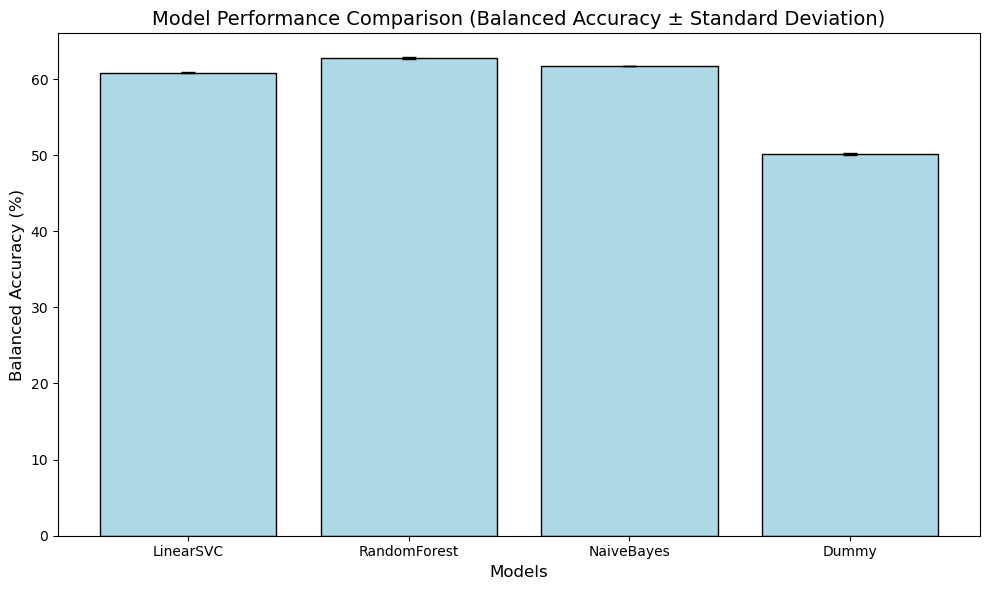

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

models = ['LinearSVC', 'RandomForest', 'NaiveBayes', 'Dummy']
mean_scores = [60.83, 62.75, 61.72, 50.11]
std_scores = [0.04, 0.11, 0.04, 0.15] 

plt.figure(figsize=(10, 6))
bars = plt.bar(models, mean_scores, yerr=std_scores, capsize=5, color='lightblue', edgecolor='black')
plt.title('Model Performance Comparison (Balanced Accuracy ± Standard Deviation)', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Balanced Accuracy (%)', fontsize=12)
for bar in bars:
    bar.set_height(bar.get_height())
plt.tight_layout()
plt.show()
